<a href="https://colab.research.google.com/github/ritwikraha/computer-needs-glasses/blob/master/image-generation/Image2Image_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image to Image with a LoRA adapter

Experiment #1 of using a LoRA adapter with Image2Image pipeline.

## Setup and Installation

In [1]:
!pip install diffusers accelerate -q

In [3]:
import requests
import io
import torch
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
from urllib.request import urlopen
from diffusers import LCMScheduler, AutoPipelineForText2Image
from diffusers import StableDiffusionImg2ImgPipeline, AutoPipelineForImage2Image

## Load the Models

In [4]:
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
adapter_id = "latent-consistency/lcm-lora-sdxl"

pipe = AutoPipelineForImage2Image.from_pretrained(model_id,
                                                  torch_dtype=torch.float16,
                                                  variant="fp16")

pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

generator = torch.Generator(device="cuda").manual_seed(33)
# load and fuse lcm lora
pipe.load_lora_weights(adapter_id)
pipe.fuse_lora()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


pytorch_lora_weights.safetensors:   0%|          | 0.00/394M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/loaders/lora.py:1078: FutureWarning: `fuse_text_encoder_lora` is deprecated and will be removed in version 0.27. You are using an old version of LoRA backend. This will be deprecated in the next releases in favor of PEFT make sure to install the latest PEFT and transformers packages in the future.
  deprecate("fuse_text_encoder_lora", "0.27", LORA_DEPRECATION_MESSAGE)


## Resize Image with Aspect Ratio

Adapted from the code here: https://huggingface.co/sayakpaul/mgie

In [5]:
def resize_image_from_url_with_aspect_ratio(url, base_width=1024, base_height=None):
    try:
        with urlopen(url) as response:
            raw_data = response.read()
        img = Image.open(io.BytesIO(raw_data)).convert("RGB")

        # Get the current width and height of the image
        width, height = img.size

        # Calculate the new dimensions based on the aspect ratio
        if base_width is not None:
            # Calculate new height based on the base_width to maintain aspect ratio
            w_percent = (base_width / float(width))
            h_size = int((float(height) * float(w_percent)))
            new_size = (base_width, h_size)
        elif base_height is not None:
            # Calculate new width based on the base_height to maintain aspect ratio
            h_percent = (base_height / float(height))
            w_size = int((float(width) * float(h_percent)))
            new_size = (w_size, base_height)
        else:
            raise ValueError("Either base_width or base_height must be provided")

        # Resize the image
        resized_img = img.resize(new_size, Image.ANTIALIAS)
        return resized_img
    except Exception as e:
        print(f"Error loading or resizing image from URL: {e}")
        return None


<ipython-input-5-a8d817d202be>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize(new_size, Image.ANTIALIAS)


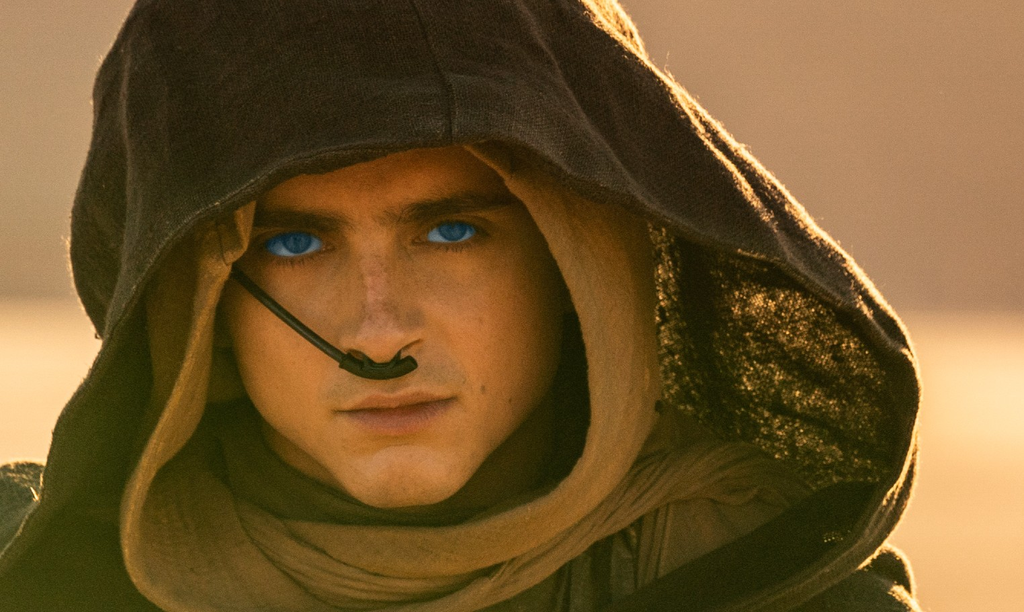

In [6]:
url = "https://www.denofgeek.com/wp-content/uploads/2023/05/dune-2-paul-atreides-timothee-chalamet.jpg"
init_image = resize_image_from_url_with_aspect_ratio(url)
init_image

## Inference



In [7]:
prompt = "A pensieve, moody illustration of Paul Atreides with a hood over his head and glowing blue eyes and spice all around, in the style of a renessaince painting"
negative_prompt = """lowres, bad anatomy, bad hands, bad eyes, facial hair
                  ugly face, bad face, smudged skin,
                  extra fingers, text, error, missing fingers,
                  extra digit, fewer digits, cropped, worst quality,
                  low quality, normal quality, jpeg artifacts,
                  signature, watermark, username, blurry"""

  0%|          | 0/12 [00:00<?, ?it/s]

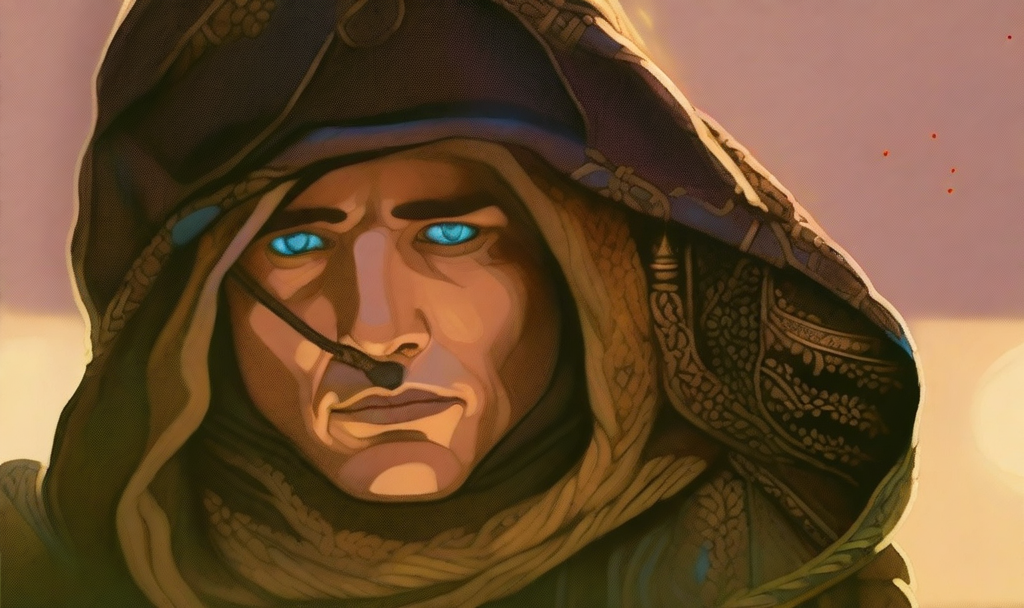

In [9]:
output = pipe(prompt=prompt,
              negative_prompt=negative_prompt,
              image=init_image,
              strength=0.25,
              guidance_scale=5,
              num_inference_steps=50,
              generator=generator).images[0]
output